In [91]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import random as rn 
import warnings
warnings.filterwarnings("ignore")

In [92]:

# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


In [93]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [94]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [95]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [96]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [97]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [98]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [99]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [100]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [101]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [102]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [103]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [104]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [105]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [106]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [107]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [108]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

### silver ground truth annotations - from original publication


In [19]:
ground_truth_annotations = pd.read_csv("../../../data/Granja2019/BMMC_D6T1/03_cellIDs_and_annotations/metadata.csv")

In [20]:
ground_truth_annotations.shape

(12394, 10)

In [21]:
ground_truth_annotations = ground_truth_annotations[["BioClassification", "Barcode"]]
ground_truth_annotations[['cluster_id', 'annotation']] = ground_truth_annotations['BioClassification'].str.split('_', n=1, expand=True)
ground_truth_annotations.index=ground_truth_annotations['Barcode']
ground_truth_annotations.index.name = None
ground_truth_annotations.columns = ["BioClassification","cell_IDs","cluster_id","annotation"]

In [22]:
set(ground_truth_annotations.annotation)

{'B',
 'CD14.Mono.1',
 'CD14.Mono.2',
 'CD4.M',
 'CD4.N1',
 'CD4.N2',
 'CD8.CM',
 'CD8.EM',
 'CD8.N',
 'CLP.1',
 'CLP.2',
 'CMP.LMPP',
 'Early.Baso',
 'Early.Eryth',
 'GMP',
 'GMP.Neut',
 'HSC',
 'Late.Eryth',
 'NK',
 'Plasma',
 'Pre.B',
 'Unk',
 'cDC',
 'pDC'}

In [23]:
ground_truth_renaming_dict={'B':'Bcell',
 'CD14.Mono.1':'Mono',
 'CD14.Mono.2':'Mono',
 'CD4.M':'CD4Tcell',
 'CD4.N1':'CD4Tcell',
 'CD4.N2':'CD4Tcell',
 'CD8.CM':'CD8Tcell',
 'CD8.EM':'CD8Tcell',
 'CD8.N':'CD8Tcell',
 'Early.Baso':'Basofil',
 'GMP':'GMP',
 'HSC':'HSC/MPP',
 'NK':'NKcell',
 'Plasma':'Plasmacell',
 'Unk':'Unknown',
 'cDC':'cDC',
 'pDC':'pDC',
 'CLP.1': 'CLP',
 'CLP.2': 'CLP',
 'CMP.LMPP': 'CMP/LMPP',
 'Early.Eryth': 'Ery',
 'GMP.Neut': 'GMP',
 'Late.Eryth': 'Ery',
 'Pre.B': 'CLP'}

In [24]:
ground_truth_annotations= ground_truth_annotations.assign(ground_truth_annotations_simplified=list(ground_truth_annotations['annotation'].map(ground_truth_renaming_dict)))
ground_truth_annotations.head()

,BioClassification,cell_IDs,cluster_id,annotation,ground_truth_annotations_simplified
CACCTGTTCTTTATCG-1,11_CD14.Mono.1,CACCTGTTCTTTATCG-1,11,CD14.Mono.1,Mono
GCCCAGAAGTGTCACT-1,16_Pre.B,GCCCAGAAGTGTCACT-1,16,Pre.B,CLP
CCTTAATCAGTATACC-1,11_CD14.Mono.1,CCTTAATCAGTATACC-1,11,CD14.Mono.1,Mono
GTGCCAGTCAAGGCAG-1,13_Unk,GTGCCAGTCAAGGCAG-1,13,Unk,Unknown
TGTGTCCAGAAAGCAG-1,11_CD14.Mono.1,TGTGTCCAGAAAGCAG-1,11,CD14.Mono.1,Mono


In [25]:
set(ground_truth_annotations.ground_truth_annotations_simplified)

{'Basofil',
 'Bcell',
 'CD4Tcell',
 'CD8Tcell',
 'CLP',
 'CMP/LMPP',
 'Ery',
 'GMP',
 'HSC/MPP',
 'Mono',
 'NKcell',
 'Plasmacell',
 'Unknown',
 'cDC',
 'pDC'}

In [26]:
ground_truth_annotations.ground_truth_annotations_simplified.value_counts()

ground_truth_annotations_simplified
CD4Tcell      2846
Mono          2789
GMP           1503
CLP           1244
CD8Tcell      1052
Unknown        616
Bcell          567
Ery            376
pDC            346
NKcell         313
CMP/LMPP       293
Basofil        190
HSC/MPP        125
cDC            111
Plasmacell      23
Name: count, dtype: int64

In [27]:
ground_truth_annotations.shape

(12394, 5)

In [28]:
ground_truth_annotations_known = ground_truth_annotations[ground_truth_annotations['ground_truth_annotations_simplified']!= "Unknown"]

In [29]:
ground_truth_annotations_known.shape

(11778, 5)

### seurat annotations

In [30]:
seurat_labelTransfer_annotations = pd.read_csv("../../../results/Fig7-Granja_BMMC_scATAC/Fig7-apply_seurat_label_transfer/Granja2019_BMMC_seurat_label_transfer_annotations.csv")
seurat_labelTransfer_annotations.columns = ["cell_IDs", "label_transfer_annotations"]
seurat_labelTransfer_annotations.index = seurat_labelTransfer_annotations.cell_IDs
seurat_labelTransfer_annotations.index.name = None
seurat_labelTransfer_annotations

,cell_IDs,label_transfer_annotations
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,CD8 Naive
TATGTTCAGGGTTCCC-1,TATGTTCAGGGTTCCC-1,CD14 Mono
GTTATGGCAACTAGAA-1,GTTATGGCAACTAGAA-1,CD14 Mono
GTAGGAGCATTATGGC-1,GTAGGAGCATTATGGC-1,CD14 Mono
CCCACATGTCTCGGGT-1,CCCACATGTCTCGGGT-1,Prog_RBC
...,...,...
TTAGGTGGTGGCCTTG-1,TTAGGTGGTGGCCTTG-1,NK
ACCGAATTCTGATCTT-1,ACCGAATTCTGATCTT-1,CD14 Mono
GCTTGCTTCGAGGTCC-1,GCTTGCTTCGAGGTCC-1,CD8 Naive
TTGACGAGTTGGGAAC-1,TTGACGAGTTGGGAAC-1,Naive B


In [31]:
seurat_annotations = ['CD4 Naive', 'Prog_B 1', 'CD4 Memory', 'Prog_RBC', 'CD8 Memory_2', 'Memory B', 'NK', 'CD14 Mono', 'CD8 Naive', 'CD8 Effector_2', 'Naive B', 'HSC', 'MAIT', 'pDC', 'GMP', 'CD16 Mono', 'gdT', 'Prog_B 2', 'LMPP', 'CD8 Effector_1', 'Prog_DC', 'Plasmablast', 'cDC2', 'Prog_Mk', 'CD56 bright NK', 'CD8 Memory_1', 'Treg']
seurat_annotations_simplified = ['CD4Tcell', "CLP", 'CD4Tcell', "MEP", "CD8Tcell", "Bcell", "NKcell", "Mono", "CD8Tcell", "CD8Tcell", "Bcell", 'HSC/MPP', 'MAIT', 'pDC', 'GMP', "Mono", 'gdT', 'CLP', 'CMP/LMPP', 'CD8Tcell', "GMP", 'Plasmablast', 'cDC', "MEP", "NKcell", 'CD8Tcell', 'Treg']

seurat_annotations_and_simplified_dict = dict(zip(seurat_annotations, seurat_annotations_simplified))

print(seurat_annotations_and_simplified_dict)


{'CD4 Naive': 'CD4Tcell', 'Prog_B 1': 'CLP', 'CD4 Memory': 'CD4Tcell', 'Prog_RBC': 'MEP', 'CD8 Memory_2': 'CD8Tcell', 'Memory B': 'Bcell', 'NK': 'NKcell', 'CD14 Mono': 'Mono', 'CD8 Naive': 'CD8Tcell', 'CD8 Effector_2': 'CD8Tcell', 'Naive B': 'Bcell', 'HSC': 'HSC/MPP', 'MAIT': 'MAIT', 'pDC': 'pDC', 'GMP': 'GMP', 'CD16 Mono': 'Mono', 'gdT': 'gdT', 'Prog_B 2': 'CLP', 'LMPP': 'CMP/LMPP', 'CD8 Effector_1': 'CD8Tcell', 'Prog_DC': 'GMP', 'Plasmablast': 'Plasmablast', 'cDC2': 'cDC', 'Prog_Mk': 'MEP', 'CD56 bright NK': 'NKcell', 'CD8 Memory_1': 'CD8Tcell', 'Treg': 'Treg'}


In [32]:
seurat_labelTransfer_annotations['seurat_annotations_simp'] =list(seurat_labelTransfer_annotations["label_transfer_annotations"].map(seurat_annotations_and_simplified_dict))
seurat_labelTransfer_annotations.columns=["cell_IDs", "label_transfer_annotations", "label_transfer_annotations_simplified"]

In [33]:
seurat_labelTransfer_annotations

,cell_IDs,label_transfer_annotations,label_transfer_annotations_simplified
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,CD8 Naive,CD8Tcell
TATGTTCAGGGTTCCC-1,TATGTTCAGGGTTCCC-1,CD14 Mono,Mono
GTTATGGCAACTAGAA-1,GTTATGGCAACTAGAA-1,CD14 Mono,Mono
GTAGGAGCATTATGGC-1,GTAGGAGCATTATGGC-1,CD14 Mono,Mono
CCCACATGTCTCGGGT-1,CCCACATGTCTCGGGT-1,Prog_RBC,MEP
...,...,...,...
TTAGGTGGTGGCCTTG-1,TTAGGTGGTGGCCTTG-1,NK,NKcell
ACCGAATTCTGATCTT-1,ACCGAATTCTGATCTT-1,CD14 Mono,Mono
GCTTGCTTCGAGGTCC-1,GCTTGCTTCGAGGTCC-1,CD8 Naive,CD8Tcell
TTGACGAGTTGGGAAC-1,TTGACGAGTTGGGAAC-1,Naive B,Bcell


### scATAcat annotations

In [34]:
scATAcat_annotations = pd.read_csv("../../../results/Fig7-Granja_BMMC_scATAC/Fig7-apply_scATAcat/outputs_pairwise/scATAcat_annotations.csv")
scATAcat_annotations.index = scATAcat_annotations['cell_IDs']
scATAcat_annotations.index.name = None
scATAcat_annotations.columns = ['cell_IDs','leiden_1','scATAcat_annotation']
scATAcat_annotations

,cell_IDs,leiden_1,scATAcat_annotation
AAACGAAAGAACCATA-1,AAACGAAAGAACCATA-1,13,GMP
AAACGAAAGAGAGGTA-1,AAACGAAAGAGAGGTA-1,1,CD4Tcell
AAACGAAAGCACGTAG-1,AAACGAAAGCACGTAG-1,14,CLP
AAACGAAAGGAAACTT-1,AAACGAAAGGAAACTT-1,2,CD4Tcell
AAACGAAAGGCAGTGT-1,AAACGAAAGGCAGTGT-1,1,CD4Tcell
...,...,...,...
TTTGTGTTCAGTCAAC-1,TTTGTGTTCAGTCAAC-1,16,CMP
TTTGTGTTCCAAGAGG-1,TTTGTGTTCCAAGAGG-1,2,CD4Tcell
TTTGTGTTCCAGAATC-1,TTTGTGTTCCAGAATC-1,9,CD8Tcell
TTTGTGTTCCCGTAGG-1,TTTGTGTTCCCGTAGG-1,2,CD4Tcell


In [35]:
set(scATAcat_annotations.scATAcat_annotation)

{'Bcell',
 'CD4Tcell',
 'CD8Tcell',
 'CLP',
 'CMP',
 'GMP',
 'MEP',
 'Mono',
 'NKcell',
 'pDC'}

In [36]:
scATAcat_annotations.scATAcat_annotation = scATAcat_annotations.scATAcat_annotation.replace({"CMP": "CMP/LMPP","LMPP": "CMP/LMPP", "HSC": "HSC/MPP", "MPP": "HSC/MPP"})

In [37]:
scATAcat_annotations

,cell_IDs,leiden_1,scATAcat_annotation
AAACGAAAGAACCATA-1,AAACGAAAGAACCATA-1,13,GMP
AAACGAAAGAGAGGTA-1,AAACGAAAGAGAGGTA-1,1,CD4Tcell
AAACGAAAGCACGTAG-1,AAACGAAAGCACGTAG-1,14,CLP
AAACGAAAGGAAACTT-1,AAACGAAAGGAAACTT-1,2,CD4Tcell
AAACGAAAGGCAGTGT-1,AAACGAAAGGCAGTGT-1,1,CD4Tcell
...,...,...,...
TTTGTGTTCAGTCAAC-1,TTTGTGTTCAGTCAAC-1,16,CMP/LMPP
TTTGTGTTCCAAGAGG-1,TTTGTGTTCCAAGAGG-1,2,CD4Tcell
TTTGTGTTCCAGAATC-1,TTTGTGTTCCAGAATC-1,9,CD8Tcell
TTTGTGTTCCCGTAGG-1,TTTGTGTTCCCGTAGG-1,2,CD4Tcell


### Cellcano annotations

In [38]:
Cellcano_annotations = pd.read_csv("../../../results/Fig7-Granja_BMMC_scATAC/Fig7-apply_Cellcano/Celcano_predict_Granja2019_BMMC_scATACcelltypes.csv")

In [39]:
Cellcano_annotations.head()

,Unnamed: 0,pred_celltype,firstround_pred_celltype,entropy
0,BMMC_D6T1#TTGCCCATCGTCTTAT-1,MEP,Naive-B,2.596768
1,BMMC_D6T1#AAGATAGTCACCGCGA-1,LMPP,pDC,3.008224
2,BMMC_D6T1#GAGGTCCAGCTACGTT-1,MEP,N-CD8T2,2.701345
3,BMMC_D6T1#TACATTCTCGATAGCT-1,N-CD8T2,N-CD8T2,1.646075
4,BMMC_D6T1#TGGTCCTGTATCTGCA-1,MDP,MDP,1.858688


In [40]:
Cellcano_annotations[['prefix', 'cell_IDs']] = Cellcano_annotations.iloc[:,0].str.split("#", n=1, expand=True)
Cellcano_annotations = Cellcano_annotations[["cell_IDs", "pred_celltype"]]
Cellcano_annotations.columns = ["cell_IDs", "Cellcano_annotations"]
Cellcano_annotations.index =Cellcano_annotations["cell_IDs"]
Cellcano_annotations.index.name = None
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations
TTGCCCATCGTCTTAT-1,TTGCCCATCGTCTTAT-1,MEP
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,LMPP
GAGGTCCAGCTACGTT-1,GAGGTCCAGCTACGTT-1,MEP
TACATTCTCGATAGCT-1,TACATTCTCGATAGCT-1,N-CD8T2
TGGTCCTGTATCTGCA-1,TGGTCCTGTATCTGCA-1,MDP


In [41]:
Cellcano_annotations.Cellcano_annotations.value_counts()

Cellcano_annotations
N-CD8T2     3690
Mono2       3462
Pre-B       1134
Mat-NK2      991
MDP          825
HSC/MPP      775
Naive-B      601
EM-CDT8      578
MEP          449
LMPP         385
pDC          338
cDC          150
Mono1        135
Memory-B      91
Pro-B         41
GMP           32
GDelta-T      29
CM-CD8T       25
Plasma-B      10
Mat-NK1        2
M-CD4T         2
Name: count, dtype: int64

In [42]:
Cellcano_annotations_ = ['HSC/MPP','MEP','CMP/BMP','LMPP','CLP','Pro-B','Pre-B','GMP','MDP','pDC','cDC','Mono1','Mono2','Naive-B','Memory-B','Plasma-B','Basofil','Imm-NK','Mat-NK1','Mat-NK2','N-CD4T1','N-CD4T2','N-Treg','M-CD4T','Treg','N-CD8T1','N-CD8T2','N-CD8T3','CM-CD8T','EM-CDT8','GDelta-T']
Cellcano_annotations_simplified  =['HSC/MPP','MEP','CMP/LMPP','CMP/LMPP','CLP','CLP','CLP','GMP','GMP','pDC','cDC','Mono','Mono','Bcell','Bcell','Bcell','Basofil','NKcell','NKcell','NKcell','CD4Tcell','CD4Tcell','Treg','CD4Tcell','Treg','CD8Tcell','CD8Tcell','CD8Tcell','CD8Tcell','CD8Tcell','gdT']
Cellcano_annotations_simplified_dict = dict(zip(Cellcano_annotations_, Cellcano_annotations_simplified))

print(Cellcano_annotations_simplified_dict)

{'HSC/MPP': 'HSC/MPP', 'MEP': 'MEP', 'CMP/BMP': 'CMP/LMPP', 'LMPP': 'CMP/LMPP', 'CLP': 'CLP', 'Pro-B': 'CLP', 'Pre-B': 'CLP', 'GMP': 'GMP', 'MDP': 'GMP', 'pDC': 'pDC', 'cDC': 'cDC', 'Mono1': 'Mono', 'Mono2': 'Mono', 'Naive-B': 'Bcell', 'Memory-B': 'Bcell', 'Plasma-B': 'Bcell', 'Basofil': 'Basofil', 'Imm-NK': 'NKcell', 'Mat-NK1': 'NKcell', 'Mat-NK2': 'NKcell', 'N-CD4T1': 'CD4Tcell', 'N-CD4T2': 'CD4Tcell', 'N-Treg': 'Treg', 'M-CD4T': 'CD4Tcell', 'Treg': 'Treg', 'N-CD8T1': 'CD8Tcell', 'N-CD8T2': 'CD8Tcell', 'N-CD8T3': 'CD8Tcell', 'CM-CD8T': 'CD8Tcell', 'EM-CDT8': 'CD8Tcell', 'GDelta-T': 'gdT'}


In [43]:
Cellcano_annotations_simplified_dict.values()

dict_values(['HSC/MPP', 'MEP', 'CMP/LMPP', 'CMP/LMPP', 'CLP', 'CLP', 'CLP', 'GMP', 'GMP', 'pDC', 'cDC', 'Mono', 'Mono', 'Bcell', 'Bcell', 'Bcell', 'Basofil', 'NKcell', 'NKcell', 'NKcell', 'CD4Tcell', 'CD4Tcell', 'Treg', 'CD4Tcell', 'Treg', 'CD8Tcell', 'CD8Tcell', 'CD8Tcell', 'CD8Tcell', 'CD8Tcell', 'gdT'])

In [44]:

Cellcano_annotations= Cellcano_annotations.assign(Cellcano_annotations_simplified=list(Cellcano_annotations['Cellcano_annotations'].map(Cellcano_annotations_simplified_dict)))
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations,Cellcano_annotations_simplified
TTGCCCATCGTCTTAT-1,TTGCCCATCGTCTTAT-1,MEP,MEP
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,LMPP,CMP/LMPP
GAGGTCCAGCTACGTT-1,GAGGTCCAGCTACGTT-1,MEP,MEP
TACATTCTCGATAGCT-1,TACATTCTCGATAGCT-1,N-CD8T2,CD8Tcell
TGGTCCTGTATCTGCA-1,TGGTCCTGTATCTGCA-1,MDP,GMP


In [45]:
set(Cellcano_annotations.Cellcano_annotations_simplified)

{'Bcell',
 'CD4Tcell',
 'CD8Tcell',
 'CLP',
 'CMP/LMPP',
 'GMP',
 'HSC/MPP',
 'MEP',
 'Mono',
 'NKcell',
 'cDC',
 'gdT',
 'pDC'}

### EpiAnno annotations

In [46]:
EpiAnno_annotations = pd.read_csv("../../../results/Fig7-Granja_BMMC_scATAC/Fig7-apply_EpiAnno/predicted_labels.csv", index_col=0)
EpiAnno_annotations.columns = ["cell_IDs", "EpiAnno_annotations"]
EpiAnno_annotations.index =EpiAnno_annotations["cell_IDs"]
EpiAnno_annotations.index.name = None


In [47]:
EpiAnno_annotations.shape

(13745, 2)

In [48]:
EpiAnno_annotations

,cell_IDs,EpiAnno_annotations
TTGCCCATCGTCTTAT-1,TTGCCCATCGTCTTAT-1,HSC/MPP
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,HSC/MPP
GAGGTCCAGCTACGTT-1,GAGGTCCAGCTACGTT-1,HSC/MPP
TACATTCTCGATAGCT-1,TACATTCTCGATAGCT-1,HSC/MPP
TGGTCCTGTATCTGCA-1,TGGTCCTGTATCTGCA-1,HSC/MPP
...,...,...
TCCATCGCACAGTAGG-1,TCCATCGCACAGTAGG-1,HSC/MPP
TGTAAGCCAATGGCAG-1,TGTAAGCCAATGGCAG-1,HSC/MPP
AAGGAGCCAAATAGTG-1,AAGGAGCCAAATAGTG-1,EM-CDT8
GAGACTTAGCTAACAA-1,GAGACTTAGCTAACAA-1,CMP/BMP


In [49]:
EpiAnno_annotations_ = ['HSC/MPP','MEP','CMP/BMP','LMPP','CLP','Pro-B','Pre-B','GMP','MDP','pDC','cDC','Mono1','Mono2','Naive-B','Memory-B','Plasma-B','Basofil','Imm-NK','Mat-NK1','Mat-NK2','N-CD4T1','N-CD4T2','N-Treg','M-CD4T','Treg','N-CD8T1','N-CD8T2','N-CD8T3','CM-CD8T','EM-CDT8','GDelta-T']
EpiAnno_annotations_simplified  =[ "HSC/MPP","MEP","CMP/LMPP","CMP/LMPP","CLP","CLP","CLP","GMP","GMP","pDC","cDC","Mono","Mono","Bcell","Bcell","Bcell","Basofil","NKcell","NKcell","NKcell","CD4Tcell","CD4Tcell","Treg","CD4Tcell","Treg","CD8Tcell","CD8Tcell","CD8Tcell","CD8Tcell","CD8Tcell","gdT"]
EpiAnno_annotations_simplified_dict = dict(zip(EpiAnno_annotations_, EpiAnno_annotations_simplified))

print(EpiAnno_annotations_simplified_dict)

{'HSC/MPP': 'HSC/MPP', 'MEP': 'MEP', 'CMP/BMP': 'CMP/LMPP', 'LMPP': 'CMP/LMPP', 'CLP': 'CLP', 'Pro-B': 'CLP', 'Pre-B': 'CLP', 'GMP': 'GMP', 'MDP': 'GMP', 'pDC': 'pDC', 'cDC': 'cDC', 'Mono1': 'Mono', 'Mono2': 'Mono', 'Naive-B': 'Bcell', 'Memory-B': 'Bcell', 'Plasma-B': 'Bcell', 'Basofil': 'Basofil', 'Imm-NK': 'NKcell', 'Mat-NK1': 'NKcell', 'Mat-NK2': 'NKcell', 'N-CD4T1': 'CD4Tcell', 'N-CD4T2': 'CD4Tcell', 'N-Treg': 'Treg', 'M-CD4T': 'CD4Tcell', 'Treg': 'Treg', 'N-CD8T1': 'CD8Tcell', 'N-CD8T2': 'CD8Tcell', 'N-CD8T3': 'CD8Tcell', 'CM-CD8T': 'CD8Tcell', 'EM-CDT8': 'CD8Tcell', 'GDelta-T': 'gdT'}


In [50]:

EpiAnno_annotations= EpiAnno_annotations.assign(EpiAnno_annotations_simplified=list(EpiAnno_annotations['EpiAnno_annotations'].map(EpiAnno_annotations_simplified_dict)))
EpiAnno_annotations.head()

,cell_IDs,EpiAnno_annotations,EpiAnno_annotations_simplified
TTGCCCATCGTCTTAT-1,TTGCCCATCGTCTTAT-1,HSC/MPP,HSC/MPP
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,HSC/MPP,HSC/MPP
GAGGTCCAGCTACGTT-1,GAGGTCCAGCTACGTT-1,HSC/MPP,HSC/MPP
TACATTCTCGATAGCT-1,TACATTCTCGATAGCT-1,HSC/MPP,HSC/MPP
TGGTCCTGTATCTGCA-1,TGGTCCTGTATCTGCA-1,HSC/MPP,HSC/MPP


## combine the annotations for the common cells:


In [51]:
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations)

In [52]:
pd.DataFrame(common_cells).to_csv("../../../results/Fig7-Granja_BMMC_scATAC/compare_annotation_performances/commonCells.csv",index=False)

In [53]:
scATAcat_annotations

,cell_IDs,leiden_1,scATAcat_annotation
AAACGAAAGAACCATA-1,AAACGAAAGAACCATA-1,13,GMP
AAACGAAAGAGAGGTA-1,AAACGAAAGAGAGGTA-1,1,CD4Tcell
AAACGAAAGCACGTAG-1,AAACGAAAGCACGTAG-1,14,CLP
AAACGAAAGGAAACTT-1,AAACGAAAGGAAACTT-1,2,CD4Tcell
AAACGAAAGGCAGTGT-1,AAACGAAAGGCAGTGT-1,1,CD4Tcell
...,...,...,...
TTTGTGTTCAGTCAAC-1,TTTGTGTTCAGTCAAC-1,16,CMP/LMPP
TTTGTGTTCCAAGAGG-1,TTTGTGTTCCAAGAGG-1,2,CD4Tcell
TTTGTGTTCCAGAATC-1,TTTGTGTTCCAGAATC-1,9,CD8Tcell
TTTGTGTTCCCGTAGG-1,TTTGTGTTCCCGTAGG-1,2,CD4Tcell


In [54]:
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")

In [55]:
all_methods_for_commonCells

,cell_IDs,leiden_1,scATAcat_annotation,label_transfer_annotations,label_transfer_annotations_simplified,BioClassification,cluster_id,annotation,ground_truth_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified
0,AGACAAAGTCCCTAAA-1,3,Mono,CD14 Mono,Mono,12_CD14.Mono.2,12,CD14.Mono.2,Mono,Mono2,Mono,HSC/MPP,HSC/MPP
1,AGCGTATTCACCCGGA-1,5,Mono,CD14 Mono,Mono,07_GMP,07,GMP,GMP,MDP,GMP,HSC/MPP,HSC/MPP
2,TTTGGCCGTTTCCACC-1,4,Bcell,Prog_B 1,CLP,16_Pre.B,16,Pre.B,CLP,Pre-B,CLP,HSC/MPP,HSC/MPP
3,CAAGAAATCAGATACC-1,2,CD4Tcell,CD14 Mono,Mono,22_CD4.M,22,CD4.M,CD4Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
4,AGCCCGACAATTGCCA-1,4,Bcell,Naive B,Bcell,16_Pre.B,16,Pre.B,CLP,Pre-B,CLP,HSC/MPP,HSC/MPP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,GCACGGTAGTTCAACC-1,0,Mono,CD14 Mono,Mono,11_CD14.Mono.1,11,CD14.Mono.1,Mono,Mono2,Mono,HSC/MPP,HSC/MPP
10748,TTCGATTGTTTCCTAT-1,4,Bcell,Naive B,Bcell,16_Pre.B,16,Pre.B,CLP,Pre-B,CLP,HSC/MPP,HSC/MPP
10749,CAATCCCAGCGTCTGC-1,4,Bcell,Naive B,Bcell,16_Pre.B,16,Pre.B,CLP,Pre-B,CLP,HSC/MPP,HSC/MPP
10750,GACTAACAGTGATCTC-1,2,CD4Tcell,CD4 Naive,CD4Tcell,22_CD4.M,22,CD4.M,CD4Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP


In [56]:
all_methods_for_commonCells.columns

Index(['cell_IDs', 'leiden_1', 'scATAcat_annotation',
       'label_transfer_annotations', 'label_transfer_annotations_simplified',
       'BioClassification', 'cluster_id', 'annotation',
       'ground_truth_annotations_simplified', 'Cellcano_annotations',
       'Cellcano_annotations_simplified', 'EpiAnno_annotations',
       'EpiAnno_annotations_simplified'],
      dtype='object')

In [57]:
for i in [scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations]:
    print(i.shape)
print(all_methods_for_commonCells.shape)

(11333, 3)
(11820, 3)
(11778, 5)
(13745, 3)
(13745, 3)
(10752, 13)


## subset the ground truth to common annotations


In [58]:
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                          &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
common_annotations

['CD8Tcell']

In [59]:
common_annotations_witho_epianno = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified))
                         # &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
common_annotations_witho_epianno

['Mono', 'Bcell', 'NKcell', 'CLP', 'CD8Tcell', 'GMP', 'pDC']

In [60]:
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]

In [61]:
all_methods_for_commonCells_commonAnnotations

,cell_IDs,leiden_1,scATAcat_annotation,label_transfer_annotations,label_transfer_annotations_simplified,BioClassification,cluster_id,annotation,ground_truth_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified
11,TCAGTTTAGGAGTACC-1,9,CD8Tcell,NK,NKcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
21,AATGGCTCACATAAAG-1,7,CD4Tcell,CD8 Naive,CD8Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
28,AGCTGTAAGATGAGGA-1,9,CD8Tcell,cDC2,cDC,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
49,CTCAGAAAGACTTCCA-1,9,CD8Tcell,NK,NKcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
63,AGTGTACCATTAGCCA-1,9,CD8Tcell,CD8 Effector_1,CD8Tcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10708,ACATGCAGTCAACTGT-1,7,CD4Tcell,CD14 Mono,Mono,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
10716,GAACTTGTCCTATCAT-1,7,CD4Tcell,CD8 Naive,CD8Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
10722,GATCATGCACAGAAGC-1,7,CD4Tcell,CD8 Naive,CD8Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
10746,GCATTGAAGCGTAGCA-1,9,CD8Tcell,CD8 Effector_2,CD8Tcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP


In [62]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"])


In [63]:
all_methods_for_commonCells_commonAnnotations.columns

Index(['cell_IDs', 'leiden_1', 'scATAcat_annotation',
       'label_transfer_annotations', 'label_transfer_annotations_simplified',
       'BioClassification', 'cluster_id', 'annotation',
       'ground_truth_annotations_simplified', 'Cellcano_annotations',
       'Cellcano_annotations_simplified', 'EpiAnno_annotations',
       'EpiAnno_annotations_simplified'],
      dtype='object')

## scores only for common cells and common annotations - only cd8 t cells

In [64]:
all_methods_for_commonCells_commonAnnotations

,cell_IDs,leiden_1,scATAcat_annotation,label_transfer_annotations,label_transfer_annotations_simplified,BioClassification,cluster_id,annotation,ground_truth_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified
11,TCAGTTTAGGAGTACC-1,9,CD8Tcell,NK,NKcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
21,AATGGCTCACATAAAG-1,7,CD4Tcell,CD8 Naive,CD8Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
28,AGCTGTAAGATGAGGA-1,9,CD8Tcell,cDC2,cDC,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
49,CTCAGAAAGACTTCCA-1,9,CD8Tcell,NK,NKcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
63,AGTGTACCATTAGCCA-1,9,CD8Tcell,CD8 Effector_1,CD8Tcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10708,ACATGCAGTCAACTGT-1,7,CD4Tcell,CD14 Mono,Mono,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
10716,GAACTTGTCCTATCAT-1,7,CD4Tcell,CD8 Naive,CD8Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
10722,GATCATGCACAGAAGC-1,7,CD4Tcell,CD8 Naive,CD8Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
10746,GCATTGAAGCGTAGCA-1,9,CD8Tcell,CD8 Effector_2,CD8Tcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP


In [65]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                          &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
annotation_df = all_methods_for_commonCells_commonAnnotations
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations_simplified"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [66]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.437059,0.437059,0.25,0.608269,0.608269,1.0,0.437059,0.0,0.0,0.0
Seurat_label_transfer,0.638469,0.638469,1.0,0.779348,0.779348,1.0,0.638469,0.0,0.0,0.0
Cellcano,0.975831,0.975831,1.0,0.987768,0.987768,1.0,0.975831,0.0,0.0,0.0
EpiAnno,0.005035,0.005035,0.0,0.01002,0.01002,1.0,0.005035,0.0,0.0,0.0


In [67]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.437059,0.437059,0.25,0.608269,0.608269,1.0,0.437059,0.0,0.0,0.0
Seurat_label_transfer,0.638469,0.638469,1.0,0.779348,0.779348,1.0,0.638469,0.0,0.0,0.0
Cellcano,0.975831,0.975831,1.0,0.987768,0.987768,1.0,0.975831,0.0,0.0,0.0
EpiAnno,0.005035,0.005035,0.0,0.01002,0.01002,1.0,0.005035,0.0,0.0,0.0


In [68]:
figures_dir = "../../../results/Fig7-Granja_BMMC_scATAC/compare_annotation_performances/figures/"

In [69]:
import os
os.makedirs(figures_dir,exist_ok=True)

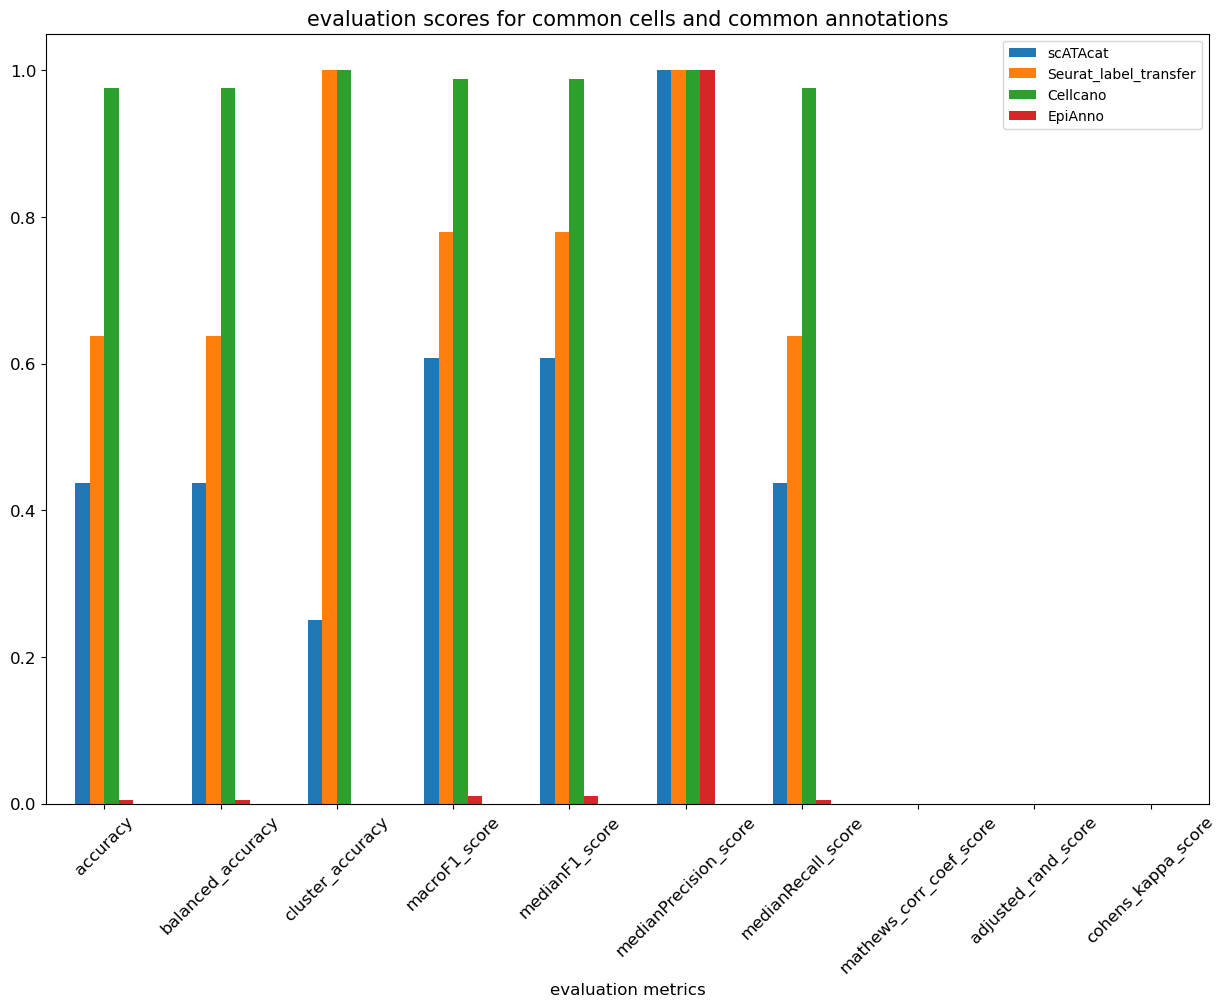

In [70]:
import matplotlib.pyplot as plt
ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
plt.title("evaluation scores for common cells and common annotations", fontsize=15)
plt.xticks(rotation=45)
#plt.show()
plt.savefig(figures_dir+ '/common_cells_common_annotations.png', bbox_inches='tight')

## scores only for common cells and common annotations - without EpiAnno

In [71]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified))
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations_witho_epianno)]
annotation_df = all_methods_for_commonCells_commonAnnotations
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations_simplified"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)

In [72]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.673455,0.690649,0.6,0.677738,0.606145,0.979661,0.91746,0.605784,0.629645,0.577621
Seurat_label_transfer,0.672748,0.653101,0.533333,0.663616,0.730836,0.832237,0.638469,0.591486,0.469821,0.56571
Cellcano,0.877952,0.873376,0.866667,0.903677,0.956443,0.967128,0.975831,0.850111,0.840161,0.84432


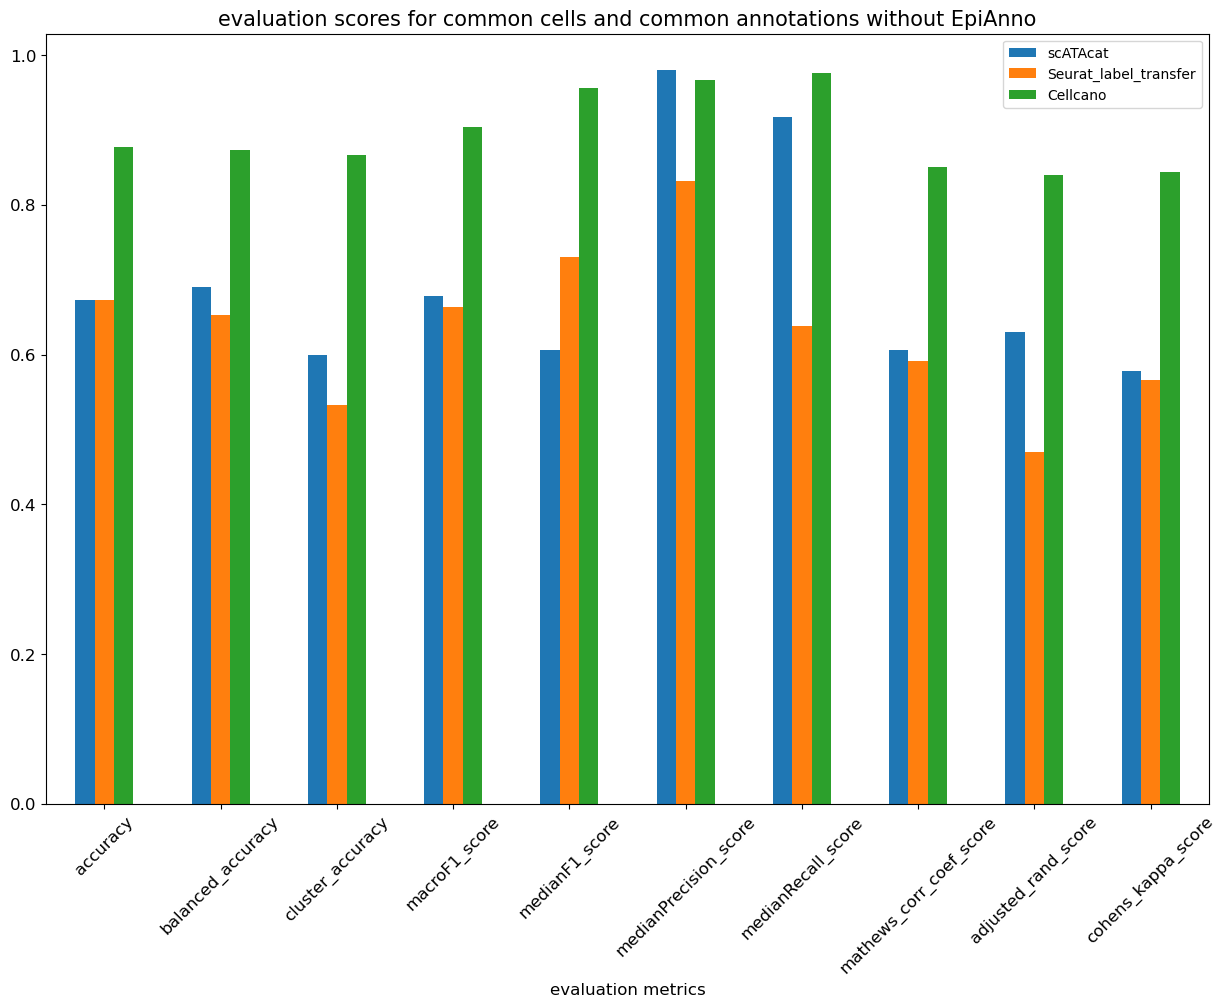

In [73]:

ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
plt.title("evaluation scores for common cells and common annotations without EpiAnno", fontsize=15)
plt.xticks(rotation=45)
#plt.show()
plt.savefig(figures_dir+ '/common_cells_common_annotations_witho_EpiAnno.png', bbox_inches='tight')

## scores for common cells & pairwise common annotations


In [74]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.673455,0.690649,0.6,0.677738,0.606145,0.979661,0.91746,0.605784,0.629645,0.577621
Seurat_label_transfer,0.672748,0.653101,0.533333,0.663616,0.730836,0.832237,0.638469,0.591486,0.469821,0.56571
Cellcano,0.877952,0.873376,0.866667,0.903677,0.956443,0.967128,0.975831,0.850111,0.840161,0.84432


In [75]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")

correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        common_annotations = list(set(all_methods_for_commonCells.label_transfer_annotations)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations        
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        common_annotations = list(set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        common_annotations = list(set(all_methods_for_commonCells.EpiAnno_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [76]:
scores_df

,accuracy,balanced_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.742026,0.648157,0.620078,0.604878,0.825776,0.91746,0.691212,0.696801,0.676632
Seurat_label_transfer,0.298447,0.408491,0.551561,0.551561,0.990843,0.408491,0.307086,0.311773,0.161835
Cellcano,0.847783,0.787422,0.743195,0.902315,0.938359,0.916551,0.816461,0.830997,0.811393
EpiAnno,0.085199,0.303997,0.05604,0.009843,0.217391,0.005035,-0.12101,0.047664,-0.016475


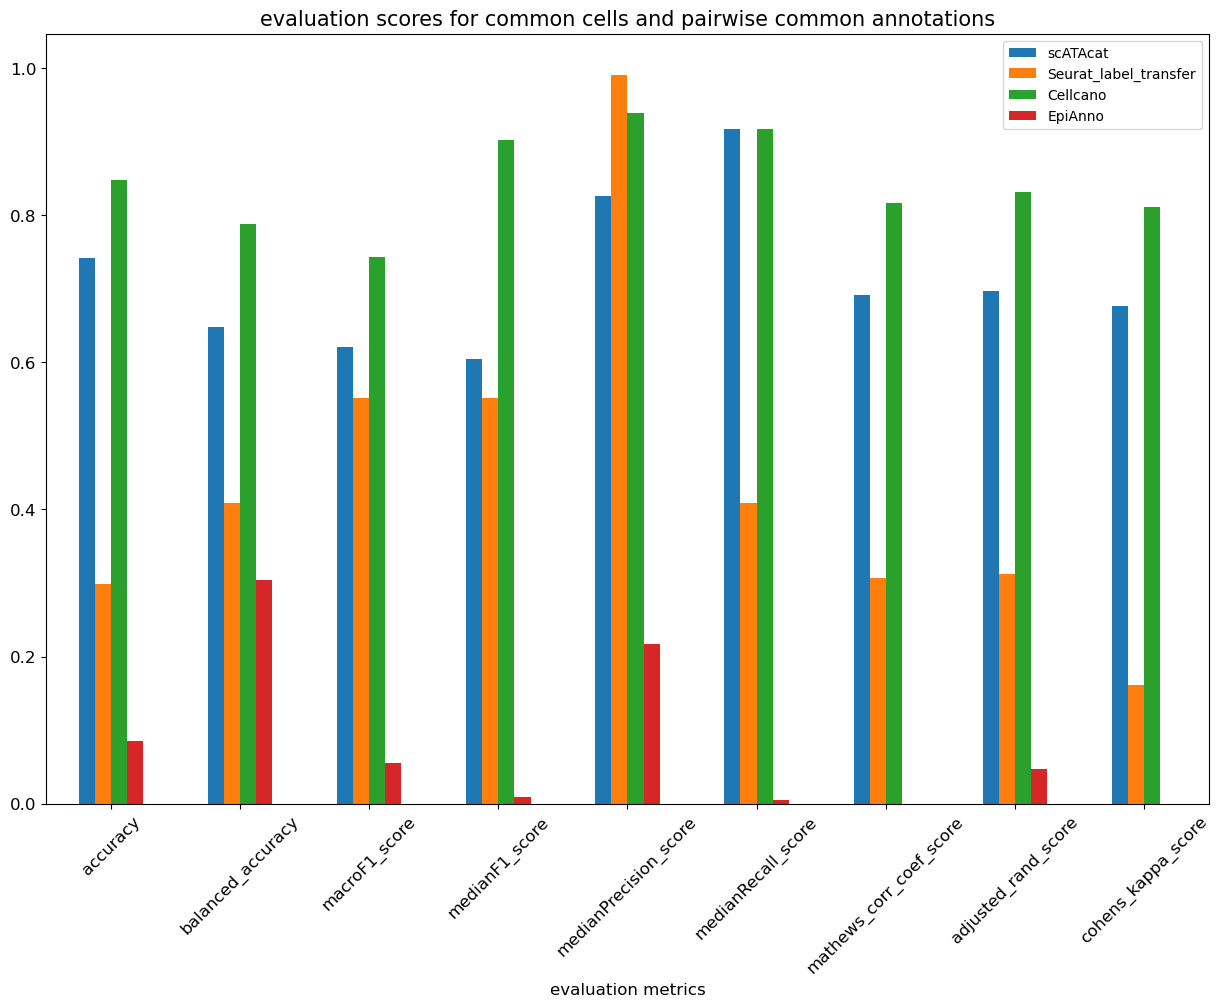

In [77]:

ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
plt.title("evaluation scores for common cells and pairwise common annotations", fontsize=15)
plt.xticks(rotation=45)
#plt.show()
plt.savefig(figures_dir+ '/common_cells_pairwise_common_annotations.png', bbox_inches='tight')

## scores for common cells - no filter for annotation

In [78]:
all_methods_for_commonCells.columns

Index(['cell_IDs', 'leiden_1', 'scATAcat_annotation',
       'label_transfer_annotations', 'label_transfer_annotations_simplified',
       'BioClassification', 'cluster_id', 'annotation',
       'ground_truth_annotations_simplified', 'Cellcano_annotations',
       'Cellcano_annotations_simplified', 'EpiAnno_annotations',
       'EpiAnno_annotations_simplified'],
      dtype='object')

In [79]:
all_methods_for_commonCells

,cell_IDs,leiden_1,scATAcat_annotation,label_transfer_annotations,label_transfer_annotations_simplified,BioClassification,cluster_id,annotation,ground_truth_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified
0,AGACAAAGTCCCTAAA-1,3,Mono,CD14 Mono,Mono,12_CD14.Mono.2,12,CD14.Mono.2,Mono,Mono2,Mono,HSC/MPP,HSC/MPP
1,AGCGTATTCACCCGGA-1,5,Mono,CD14 Mono,Mono,07_GMP,07,GMP,GMP,MDP,GMP,HSC/MPP,HSC/MPP
2,TTTGGCCGTTTCCACC-1,4,Bcell,Prog_B 1,CLP,16_Pre.B,16,Pre.B,CLP,Pre-B,CLP,HSC/MPP,HSC/MPP
3,CAAGAAATCAGATACC-1,2,CD4Tcell,CD14 Mono,Mono,22_CD4.M,22,CD4.M,CD4Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
4,AGCCCGACAATTGCCA-1,4,Bcell,Naive B,Bcell,16_Pre.B,16,Pre.B,CLP,Pre-B,CLP,HSC/MPP,HSC/MPP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,GCACGGTAGTTCAACC-1,0,Mono,CD14 Mono,Mono,11_CD14.Mono.1,11,CD14.Mono.1,Mono,Mono2,Mono,HSC/MPP,HSC/MPP
10748,TTCGATTGTTTCCTAT-1,4,Bcell,Naive B,Bcell,16_Pre.B,16,Pre.B,CLP,Pre-B,CLP,HSC/MPP,HSC/MPP
10749,CAATCCCAGCGTCTGC-1,4,Bcell,Naive B,Bcell,16_Pre.B,16,Pre.B,CLP,Pre-B,CLP,HSC/MPP,HSC/MPP
10750,GACTAACAGTGATCTC-1,2,CD4Tcell,CD4 Naive,CD4Tcell,22_CD4.M,22,CD4.M,CD4Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP


In [80]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
annotation_df = all_methods_for_commonCells
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations_simplified"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [81]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.690197,0.416673,0.555556,0.395676,0.344234,0.421539,0.244332,0.635193,0.689693,0.622773
Seurat_label_transfer,0.605655,0.403624,0.5,0.388151,0.432124,0.508216,0.374932,0.537448,0.365709,0.517944
Cellcano,0.595703,0.562444,0.555556,0.477392,0.52421,0.493905,0.784524,0.585313,0.746275,0.541277
EpiAnno,0.010975,0.065142,0.0,0.002631,0.0,0.0,0.0,-0.011088,0.001739,-0.001823


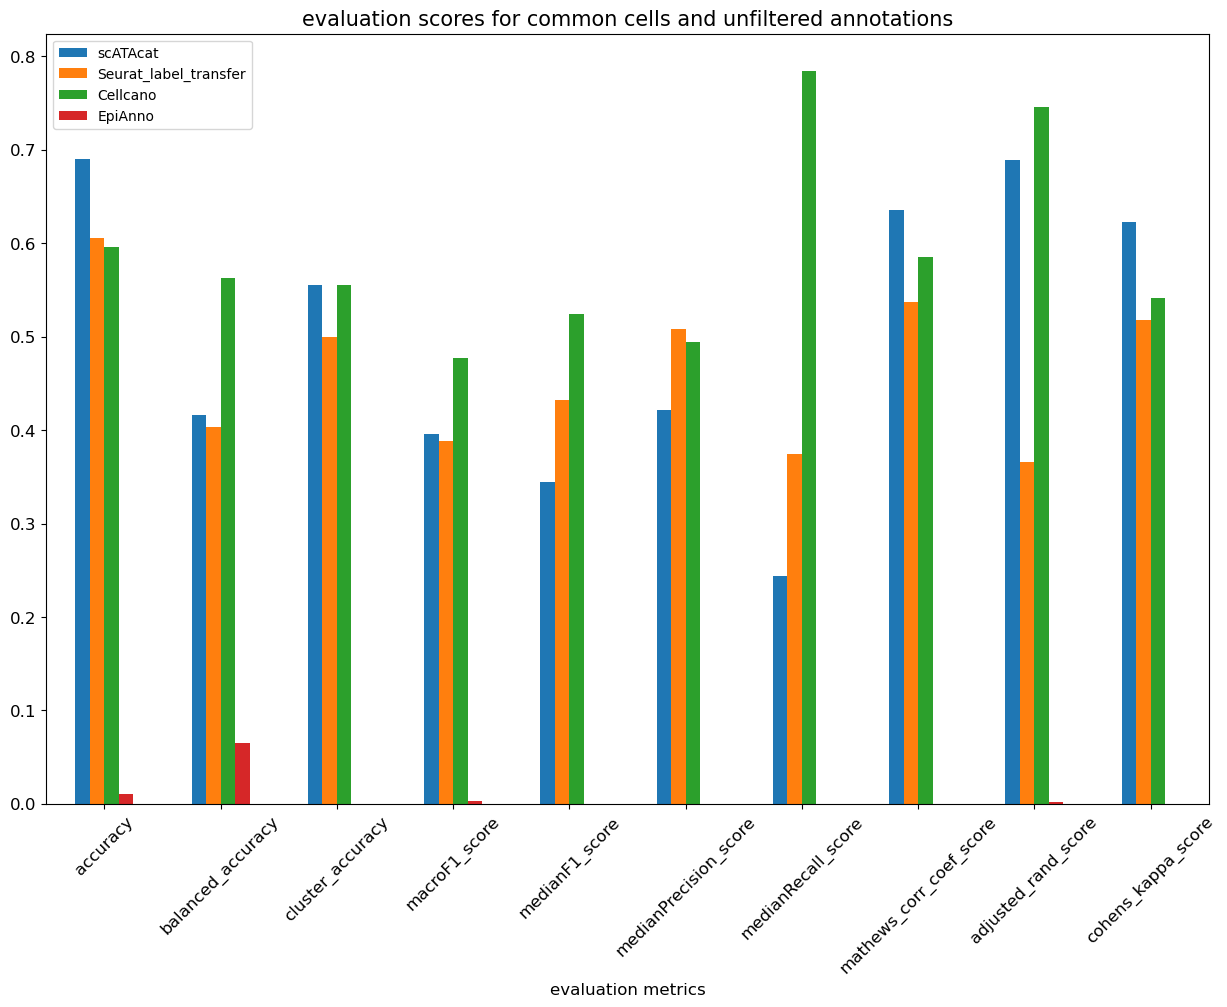

In [82]:

ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
plt.title("evaluation scores for common cells and unfiltered annotations", fontsize=15)
plt.xticks(rotation=45)
#plt.show()
plt.savefig(figures_dir+ '/common_cells_unfiltered_annotations.png', bbox_inches='tight')

## scores for pairwise common cells & no annotation filter

In [83]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
#annotation_df = all_methods_for_commonCells
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        common_cells = get_common_cells(scATAcat_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        annotation_df = all_methods_for_commonCells
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        common_cells = get_common_cells(seurat_labelTransfer_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(seurat_labelTransfer_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        annotation_df = all_methods_for_commonCells
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        common_cells = get_common_cells(Cellcano_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(Cellcano_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        annotation_df = all_methods_for_commonCells
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        common_cells = get_common_cells(EpiAnno_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(EpiAnno_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        annotation_df = all_methods_for_commonCells
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [84]:
scores_df

,accuracy,balanced_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.689768,0.416452,0.395542,0.346724,0.429741,0.245733,0.634641,0.689176,0.622205
Seurat_label_transfer,0.043672,0.058875,0.078246,0.0,0.0,0.0,0.048998,0.312909,0.03961
Cellcano,0.590762,0.561064,0.471653,0.532329,0.474065,0.781558,0.579474,0.728699,0.537297
EpiAnno,0.010104,0.065155,0.002431,0.0,0.0,0.0,-0.010537,0.001294,-0.001737


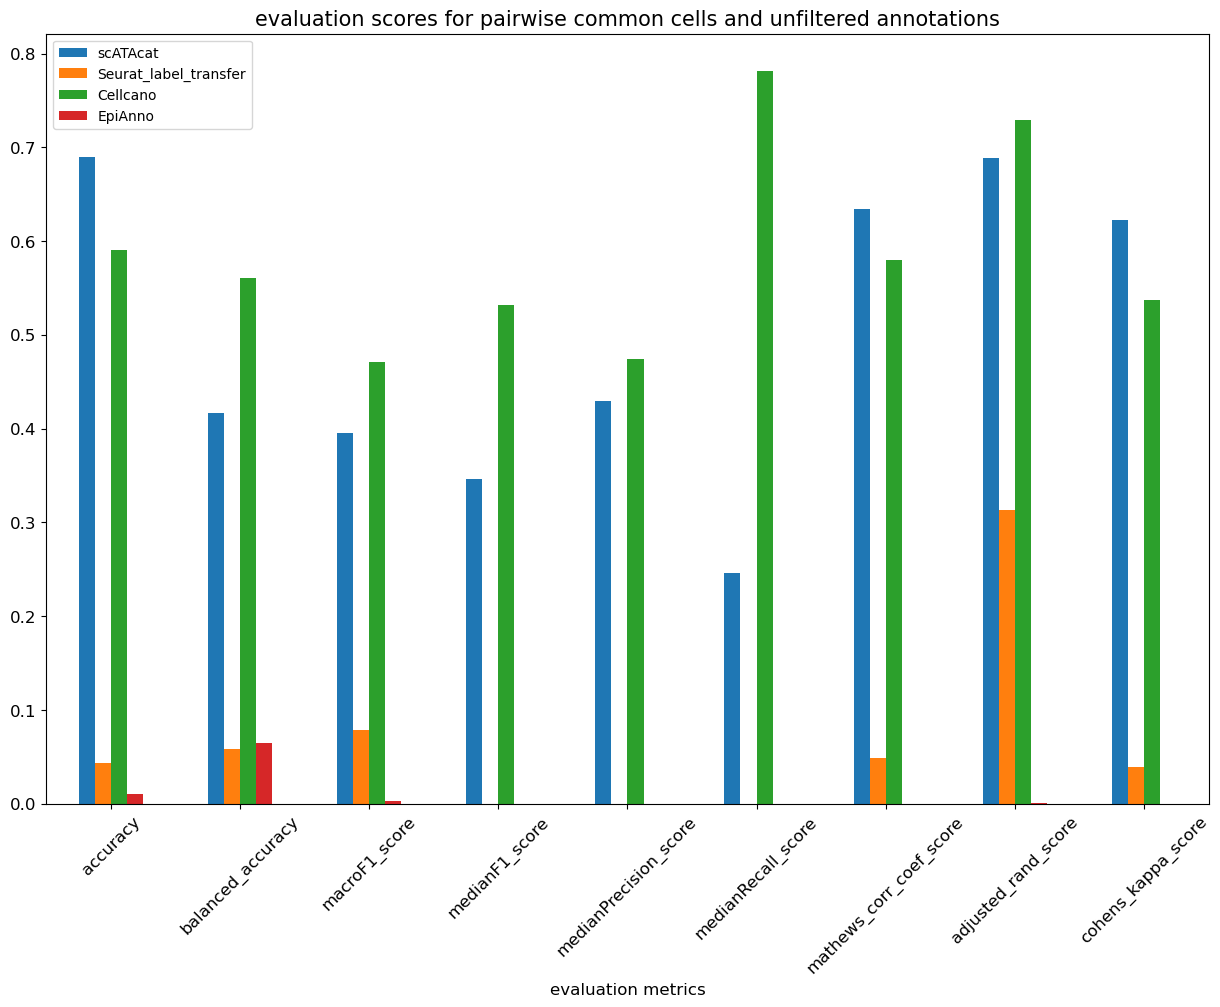

In [85]:

ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
plt.title("evaluation scores for pairwise common cells and unfiltered annotations", fontsize=15)
plt.xticks(rotation=45)
#plt.show()
plt.savefig(figures_dir+ '/pairwise_common_cells_unfiltered_annotations.png', bbox_inches='tight')

## scores for pairwise common cells & pairwise common annotations


In [86]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
#annotation_df = all_methods_for_commonCells
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        common_cells = get_common_cells(scATAcat_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        common_cells = get_common_cells(seurat_labelTransfer_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(seurat_labelTransfer_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.label_transfer_annotations)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations        
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        common_cells = get_common_cells(Cellcano_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(Cellcano_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        common_cells = get_common_cells(EpiAnno_annotations,ground_truth_annotations_known)
        all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(EpiAnno_annotations,ground_truth_annotations_known, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.EpiAnno_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        #scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [87]:
scores_df

,accuracy,balanced_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.741926,0.647814,0.619796,0.598639,0.826035,0.918239,0.690936,0.695464,0.676333
Seurat_label_transfer,0.303274,0.412124,0.555661,0.555661,0.986819,0.412124,0.304921,0.305663,0.161373
Cellcano,0.833993,0.78549,0.734467,0.885476,0.933309,0.906124,0.801716,0.798449,0.795995
EpiAnno,0.080952,0.304055,0.053321,0.009302,0.217391,0.004753,-0.117826,0.044986,-0.015498


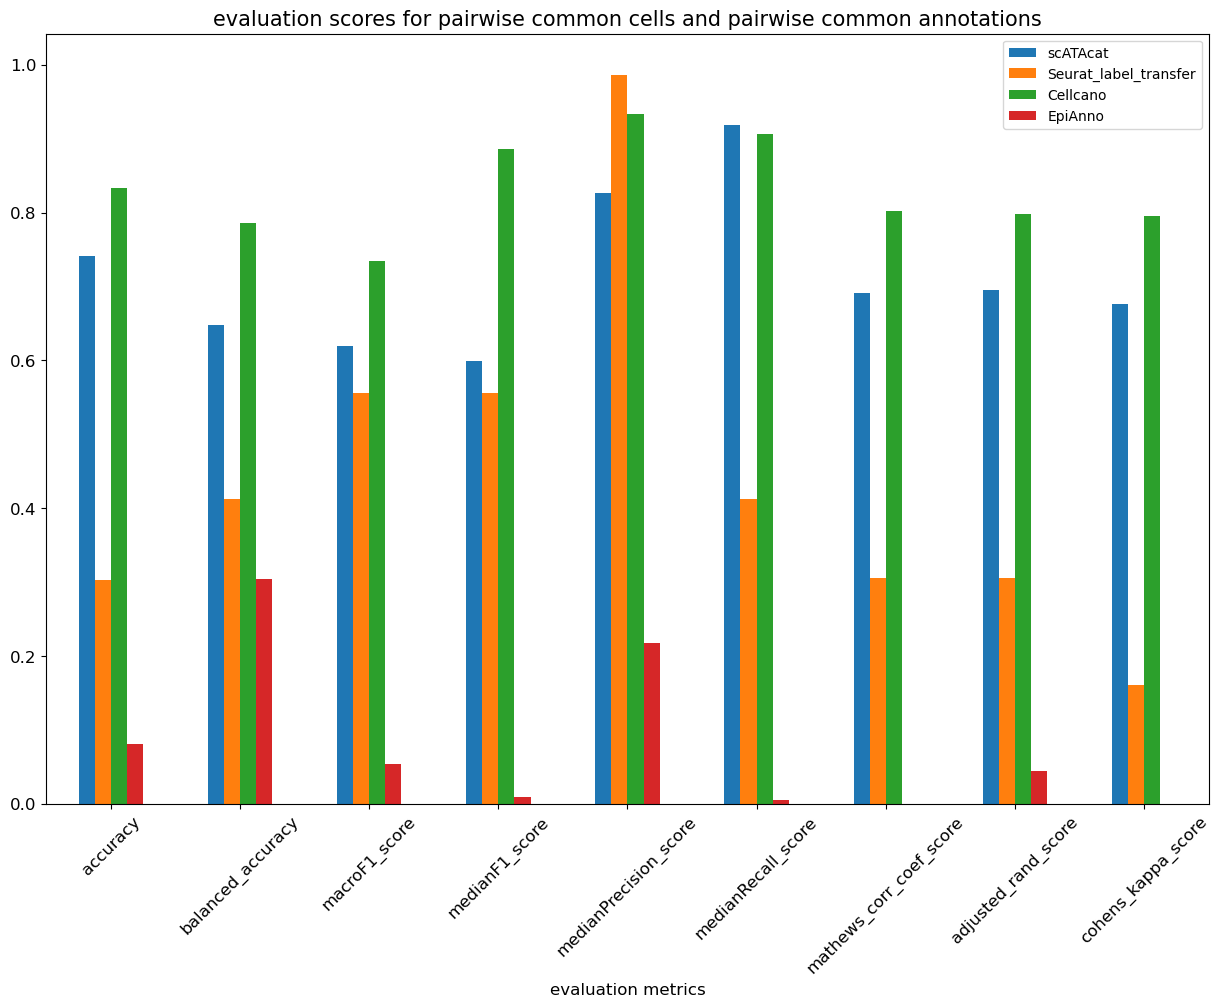

In [88]:

ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
plt.title("evaluation scores for pairwise common cells and pairwise common annotations", fontsize=15)
plt.xticks(rotation=45)
#plt.show()
plt.savefig(figures_dir+ '/pairwise_common_cells_pairwise_common_annotations.png', bbox_inches='tight')
